In [1]:
import pandas as pd

In [2]:
pip install factor_analyzer

Note: you may need to restart the kernel to use updated packages.


In [3]:
from factor_analyzer import FactorAnalyzer

In [4]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv('C:/kmeans/UIGV1311956_OP0.txt', sep='\t')

In [7]:
df.head(5)

,UID,Const,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,...,E_27,E_28,E_29,E_30,E_31,E_32,E_33,E_34,E_35,E_36
0,1311395,97.00,-18.57,9.52,-8.21,8.78,-2.36,-7.05,-17.03,-1.10,...,0.24,4.16,1.79,3.55,-17.28,-6.24,-3.01,-10.39,-14.77,-0.43
1,1311396,49.08,-10.39,-5.93,-6.21,-0.69,-0.85,-0.75,14.78,12.05,...,-12.44,-2.98,-1.55,-20.46,19.62,-1.95,12.16,19.88,6.91,28.41
2,1311397,15.51,8.22,11.68,16.48,11.85,14.33,1.97,8.11,22.31,...,25.23,10.03,-2.31,12.60,21.34,22.65,1.42,21.55,12.15,19.84
3,1311398,102.67,-6.45,-14.31,2.83,-13.21,3.70,5.54,6.60,-9.83,...,-7.13,-11.26,1.61,6.31,-0.44,-13.85,-1.76,-1.73,3.47,-11.69
4,1311400,74.15,13.68,2.96,6.57,-4.24,11.77,3.56,14.09,20.19,...,4.39,0.61,-17.85,4.01,-5.12,-13.57,-4.71,-6.06,-7.05,-16.62


In [8]:
df_fct =  df.drop(['UID','Const'], axis = 1)

In [7]:
df_fct.head()

,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,...,E_27,E_28,E_29,E_30,E_31,E_32,E_33,E_34,E_35,E_36
0,-18.57,9.52,-8.21,8.78,-2.36,-7.05,-17.03,-1.10,-6.89,-2.97,...,0.24,4.16,1.79,3.55,-17.28,-6.24,-3.01,-10.39,-14.77,-0.43
1,-10.39,-5.93,-6.21,-0.69,-0.85,-0.75,14.78,12.05,-13.98,18.30,...,-12.44,-2.98,-1.55,-20.46,19.62,-1.95,12.16,19.88,6.91,28.41
2,8.22,11.68,16.48,11.85,14.33,1.97,8.11,22.31,2.02,15.70,...,25.23,10.03,-2.31,12.60,21.34,22.65,1.42,21.55,12.15,19.84
3,-6.45,-14.31,2.83,-13.21,3.70,5.54,6.60,-9.83,-7.25,8.75,...,-7.13,-11.26,1.61,6.31,-0.44,-13.85,-1.76,-1.73,3.47,-11.69
4,13.68,2.96,6.57,-4.24,11.77,3.56,14.09,20.19,9.28,3.74,...,4.39,0.61,-17.85,4.01,-5.12,-13.57,-4.71,-6.06,-7.05,-16.62


In [7]:
fa = FactorAnalyzer(n_factors=5,rotation='quartimax')

In [8]:
fa.fit(df_fct)

FactorAnalyzer(n_factors=5, rotation='quartimax', rotation_kwargs={})

In [9]:
loadings = fa.loadings_

In [10]:
ev, v = fa.get_eigenvalues()

In [11]:
xvals = range(1, df_fct.shape[1]+1)

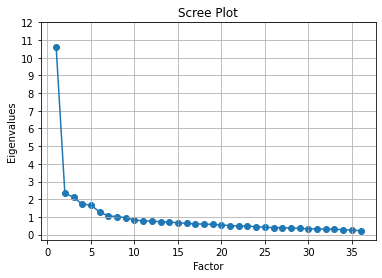

In [21]:
plt.scatter(xvals,ev)
plt.plot(xvals, ev)
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalues')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
plt.show()

In [16]:
ev

array([10.59267071,  2.33116666,  2.11377727,  1.71775964,  1.67322846,
        1.27020224,  1.06415029,  1.01468701,  0.95459751,  0.8236991 ,
        0.77574707,  0.76307285,  0.72927801,  0.70705429,  0.6709557 ,
        0.63189162,  0.60224659,  0.59349459,  0.57697191,  0.53641124,
        0.51445916,  0.48302656,  0.47663102,  0.45151838,  0.41396747,
        0.39596126,  0.39279193,  0.37517128,  0.34890969,  0.33141645,
        0.31924346,  0.30453058,  0.30095566,  0.27860251,  0.24513374,
        0.22461809])

In [17]:
v

array([ 1.00384127e+01,  1.76655893e+00,  1.57385891e+00,  1.18512982e+00,
        1.13391096e+00,  6.96962949e-01,  4.64937967e-01,  4.23663399e-01,
        3.47115063e-01,  2.29655462e-01,  2.05732370e-01,  2.01155005e-01,
        1.37720907e-01,  1.27301511e-01,  9.46998026e-02,  8.27808421e-02,
        6.90442002e-02,  1.09338178e-02,  4.89412079e-03, -1.63612698e-02,
       -4.27394901e-02, -8.11548252e-02, -8.92359590e-02, -1.13228783e-01,
       -1.34440020e-01, -1.47318115e-01, -1.74436124e-01, -1.84286635e-01,
       -2.04186908e-01, -2.15724482e-01, -2.39301301e-01, -2.59729230e-01,
       -2.80931631e-01, -2.82997622e-01, -3.07658120e-01, -3.22865387e-01])

In [12]:
eigen=pd.DataFrame(v,columns=['eigenvalues']) 


In [13]:
ev

array([10.59267071,  2.33116666,  2.11377727,  1.71775964,  1.67322846,
        1.27020224,  1.06415029,  1.01468701,  0.95459751,  0.8236991 ,
        0.77574707,  0.76307285,  0.72927801,  0.70705429,  0.6709557 ,
        0.63189162,  0.60224659,  0.59349459,  0.57697191,  0.53641124,
        0.51445916,  0.48302656,  0.47663102,  0.45151838,  0.41396747,
        0.39596126,  0.39279193,  0.37517128,  0.34890969,  0.33141645,
        0.31924346,  0.30453058,  0.30095566,  0.27860251,  0.24513374,
        0.22461809])

In [14]:
num_of_facts=sum(i >= 1 for i in ev)

In [15]:
fa = FactorAnalyzer(n_factors=num_of_facts,rotation='quartimax')

In [16]:
fa.fit(df_fct)

FactorAnalyzer(n_factors=8, rotation='quartimax', rotation_kwargs={})

In [17]:
loadings = fa.loadings_

In [18]:
len(loadings)

36

In [24]:
pip install openpyxl


  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8919 sha256=a3a016cc14935cc7aa966b541e2365231a4656aeb64b56fa8c4bb9f0b831dba9
  Stored in directory: c:\users\david\appdata\local\pip\cache\wheels\6e\df\38\abda47b884e3e25f9f9b6430e5ce44c47670758a50c0c51759
Successfully built et-xmlfile


In [26]:
import pandas as pd 
factor_scores = fa.transform(df_fct)
factor_scores = pd.DataFrame(factor_scores)
loadings = pd.DataFrame(loadings)
factor_scores.to_excel('C:/kmeans/factor_scores.xlsx')
loadings.to_excel('C:/kmeans/loadings.xlsx')


In [49]:
loadings_abs=loadings.abs()
loadings[loadings.abs() >= .4].count()



0    16
1     6
2     3
3     6
4     6
5     1
6     1
7     0
dtype: int64

Below is for KMEANS Clustering

In [38]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
import numpy as np

In [55]:
X=df_fct
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X)

In [57]:
plt.scatter(X[:,0],X[:,36], c=kmeans.labels_, cmap='rainbow')

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [56]:
clusters

array([0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0,
       1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2,
       0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0,
       0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0,

In [59]:
mglearn.plots.plot_dbscan()

NameError: name 'mglearn' is not defined

In [61]:
from sklearn.cluster import DBSCAN

In [1]:
from scipy.stats import pearsonr
import numpy as np


In [2]:
def pearson_affinity(M):
   return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])